In [1]:
import numpy as np 
import pickle

import matplotlib.pyplot as plt

import os, sys
rootpath = os.path.join(os.getcwd(), '..')
sys.path.append(rootpath)

import networkx as nx

import jax
import jax.numpy as jnp
from jax.experimental import sparse


import jax.random as random
from jax import jit,lax, vmap

from matplotlib.animation import FuncAnimation, PillowWriter
from matplotlib import cm
from matplotlib.colors import Normalize, ListedColormap
from scipy.signal import hilbert


In [2]:
#random network implementation
def random_graph(N, k, J, seed=100, weights='homogeneous', weight_generator=None):
    '''
    Creates a random, directed, and weighted Erdos Renyi graph.
    Parameters:
        N: number of nodes
        k: mean nodal degree
        J: weight parameters. If homogeneous weights: constant float, if gaussian weigts: J=(J_mean, J_sigma)
        seed: seed for the ER graph generation
        weights: Type of weights, 'homogeneous' or 'gaussian'
        generator: random generator for random weights
    Returns:
        sparse jax.experimental coupling matrix 
    '''
    p = k / (N - 1)
    
    # Create ER graph
    G = nx.erdos_renyi_graph(N, p, directed=True, seed=seed)
    
    # Put weights
    for u, v in G.edges():
        if weights=='homogeneous':
            G[u][v]['weight'] = J#generator.normal(J, J/5)
        elif weights=='gaussian':
            G[u][v]['weight'] = weight_generator.normal(J[0], J[1])
    
    # Get the adjacency matrix in sparse format
    adj_matrix = nx.adjacency_matrix(G, weight='weight')
    
    return sparse.BCSR.from_scipy_sparse(adj_matrix)

In [3]:

# Euler-Maruyama implementation getting rid of Du
k=50
m=1.45 # Mean J/k
N=1000
L= random_graph(N, k, J=m/k, weights='homogeneous')
N = 1000 # Put N here for jax to be able to JIT compile the solve_brain function pre-runtime. 

@jit
def FHN_step(u, v, N, a, b, e,  sigma, L, key, delta_t):
    
    '''
    Perform a single step of the noisy FitzHugh-Nagumo model.
    Parameters:
    - u: state variable u
    - v: state variable v
    - N: number of nodes
    - a: parameter a
    - b: parameter b
    - e: parameter e giving the timescale separation between u and v
    - sigma: noise intensity
    - L: Laplacian matrix
    - key: random key for noise generation
    - delta_t: time step
    Returns:
    - u_new: updated state variable u
    - v_new: updated state variable v
    '''
    # Generate Gaussian noise for each element of h
    noise = random.normal(key, u.shape)
    
    du = a * u * (u - b) * (1 - u) + (L @ u) - v 
    dv = e * (u - v)
    u_new = u + du * delta_t + jnp.sqrt(delta_t * sigma**2) * noise
    v_new = v + dv * delta_t

    return u_new, v_new

def run_simulation(N=N, y0='zeros', a=3, b=0.2, e=1e-2,  J=L, sigma=0.1, delta_t=0.1, total_time=3000.0, key=random.PRNGKey(0)):
    if y0=='zeros':
        y0 = jnp.zeros(2*N)
    
    if type(y0) == str and y0=='random':
        y0 = random.normal(random.PRNGKey(0), shape=(2*N,))*e
     
    # Calculate the number of steps based on the total time and delta_t
    num_steps = int(total_time / delta_t)

    # Initialize state variables
    u = y0[:N]
    v = y0[N:]

    # Define the scan function
    def scan_fn(carry, step):
        u, v, key = carry
        key, subkey = random.split(key)
        u, v = FHN_step(u, v, N, a, b, e, sigma, L, subkey, delta_t)
        return (u, v, key), (u, v)

    # Run the scan function
    (u, v, _), (u_trajectory, v_trajectory) = lax.scan(scan_fn, (u, v, key), None, length=num_steps)
    u_trajectory=u_trajectory[::10]
    v_trajectory=v_trajectory[::10]

    return u_trajectory, v_trajectory



C:\Users\pelli\AppData\Local\Temp\ipykernel_29312\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


In [4]:
N=40000

m =0.05
L= random_graph(N, k, J=m/k, weights='homogeneous')
##sol = solve_brain(L,T=T,rtol=1e-2, atol=1e-3,dt0=1e-2, noise_tol=1e-4, solver=diffrax.ShARK()) #y0=np.append(random_generator.un
u_sol, v_sol = run_simulation(N=N, J=L, a=3, b=0.2, e=0.01,  sigma=0.1, total_time=3000, key=random.PRNGKey(int(m*100+1)))

C:\Users\pelli\AppData\Local\Temp\ipykernel_10580\1428128129.py:28: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  adj_matrix = nx.adjacency_matrix(G, weight='weight')


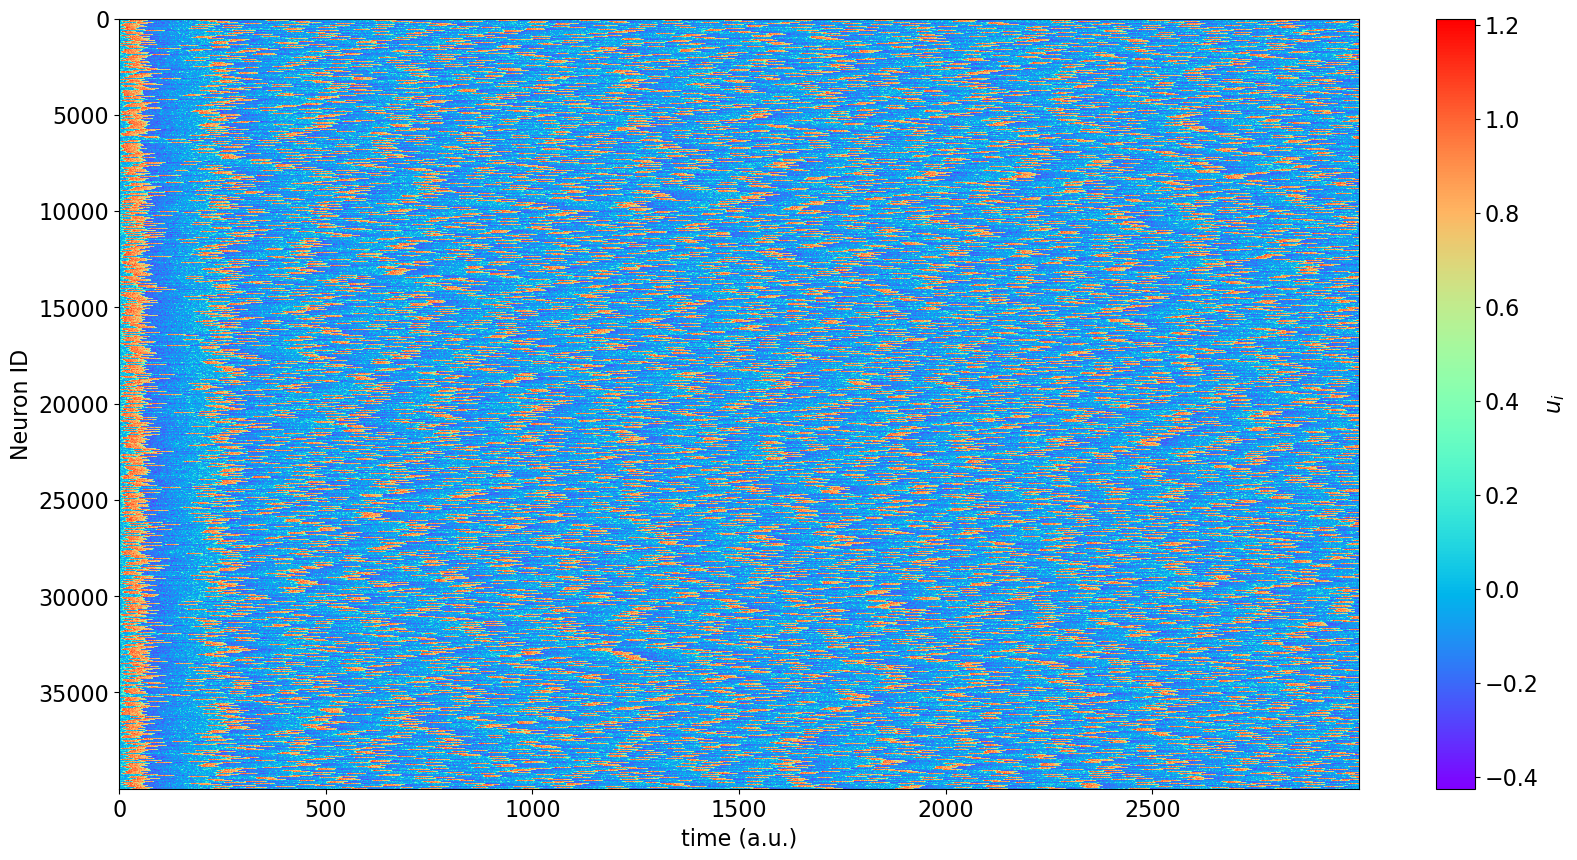

In [5]:
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,1, figsize=(20, 10))

# Kymograph with timeseries of all neurons' activities (u)
im = ax.imshow(u_sol.T, aspect='auto', cmap='rainbow', interpolation='none')
ax.set_xlabel(r'time (a.u.)')
ax.set_ylabel(r'Neuron ID')
#ax.set_title(f'm: {m_array[simulation_id]}')

# plot colorbar
cbar = fig.colorbar(im, ax=ax, label=r'$u_i$')

# Order Parameters calculations

In [ ]:
#run the simulation for a bunch of m values


m_array = np.arange(0,0.4,.005)
T=6000
t_steps=6000
u_solutions = np.empty((len(m_array),N, t_steps))
for i,m in enumerate(m_array):
    L=random_graph(N,k,J=m/k)
    print("{}/{}, m={}".format(i+1,len(m_array), m))
    ##sol = solve_brain(L,T=T,rtol=1e-2, atol=1e-3,dt0=1e-2, noise_tol=1e-4, solver=diffrax.ShARK()) #y0=np.append(random_generator.uniform(0,0.4, size=N), (random_generator.integers(0,2, size=N))*1)
    u_sol, v_sol= run_simulation(N=N,J=L, a=3, b=0.2, e=0.01, sigma=0.1, total_time=T, key=random.PRNGKey(int(m*100+1)))
    u_solutions[i] = u_sol.T # u over time

In [68]:
filepath = 'data/brain_phase-transition_homogeneousJ.pkl'
with open(filepath,'wb') as f:
    pickle.dump(u_solutions, f)
    

In [2]:
#load the data
u_solutions_loaded = np.load('data/brain_phase-transition_homogeneousJ.pkl',allow_pickle=True)

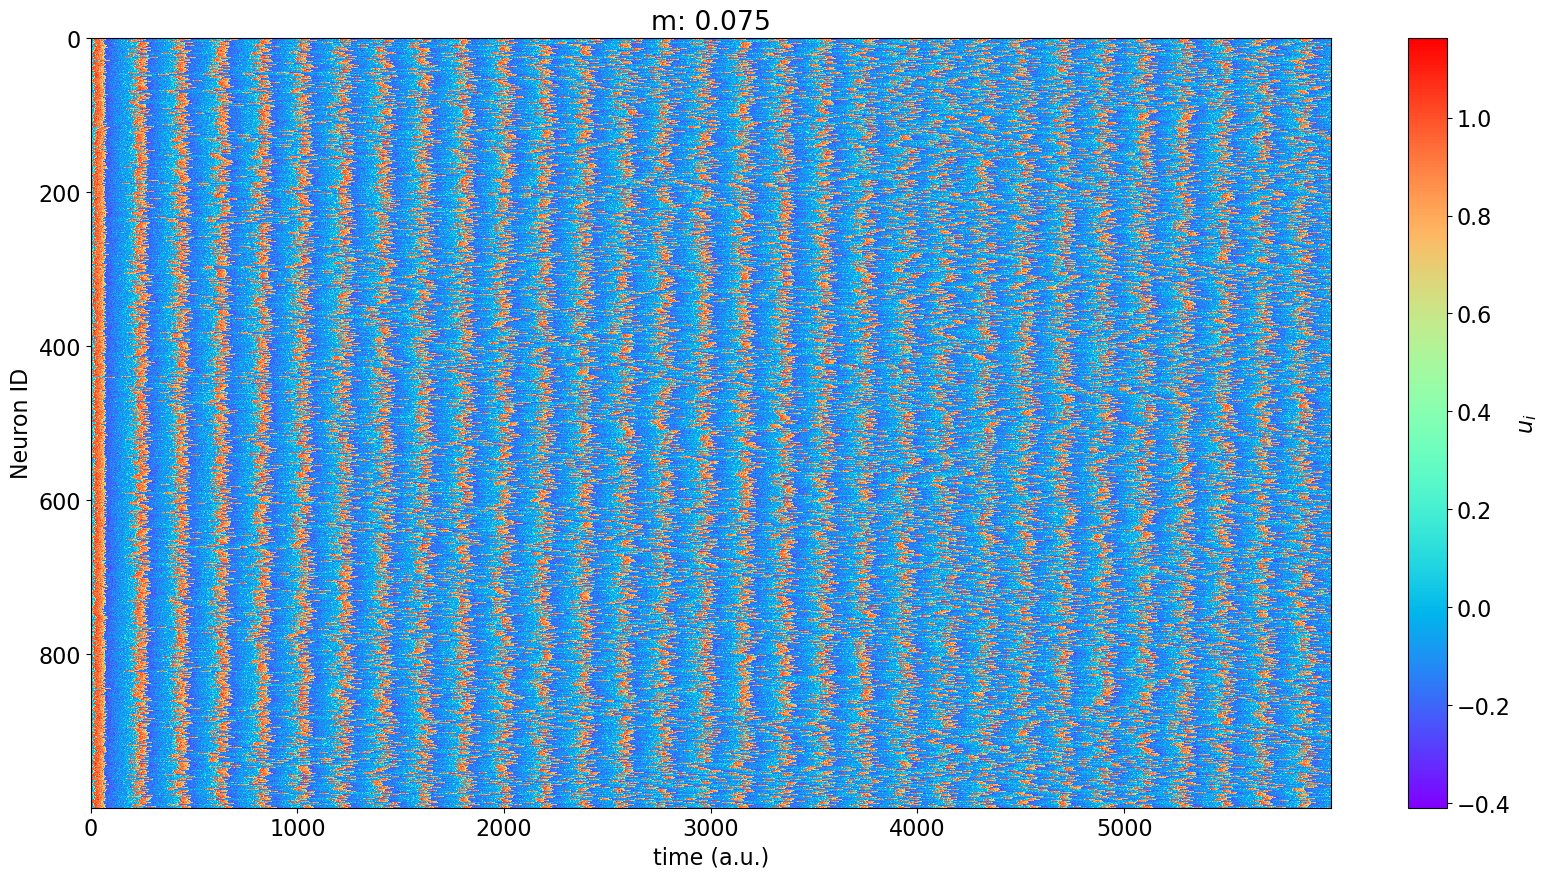

In [70]:
#plot the kymograph for a single m value

simulation_id = 15 # which simulation to look at
m_array = np.arange(0,0.4,.005)
plt.rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,1, figsize=(20, 10))

# Kymograph with timeseries of all neurons' activities (u)
im = ax.imshow(u_solutions[simulation_id], aspect='auto', cmap='rainbow', interpolation='none')
ax.set_xlabel(r'time (a.u.)')
ax.set_ylabel(r'Neuron ID')
ax.set_title(f'm: {m_array[simulation_id]}')

# plot colorbar
cbar = fig.colorbar(im, ax=ax, label=r'$u_i$')

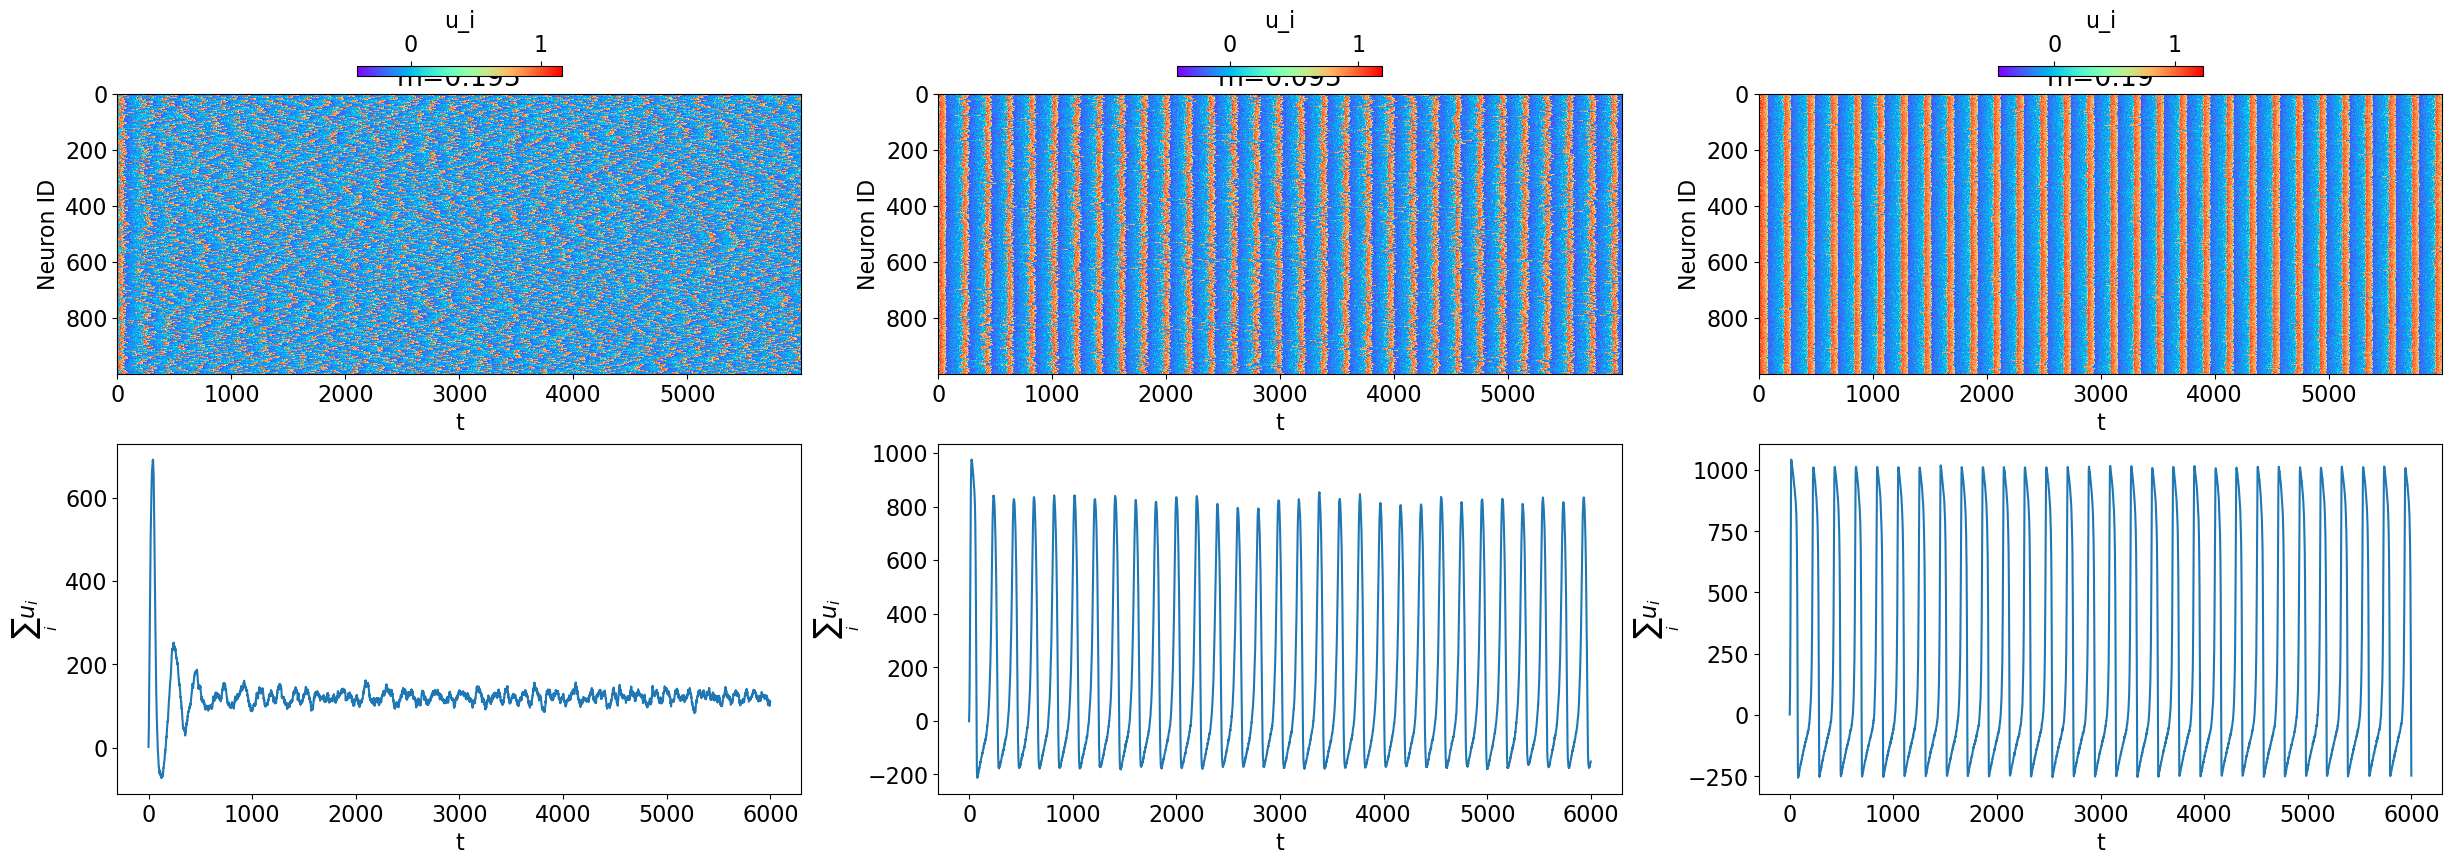

In [54]:
fig, (ax_kymographs, ax_EEGs) = plt.subplots(2, 3, figsize=(30, 10))

# Adjust the indices to be within the bounds of m_array
indices = (0, len(u_solutions) // 2, len(u_solutions) - 1)

for i, ax_kymo, ax_EEG in zip(indices, ax_kymographs, ax_EEGs):
    ax_kymo.set_title('m={}'.format(m_array[i-1]))
    # heatmap with all neurons timeseries x:t, y:neuron_id
    im = ax_kymo.imshow(u_solutions[i], aspect='auto', cmap='rainbow', interpolation='none')
    ax_kymo.set_xlabel(r't')
    ax_kymo.set_ylabel(r'Neuron ID')

    # plot colorbar
    cbar = fig.colorbar(im, ax=ax_kymo, location='top', shrink=0.3, label=r'u_i')

    # plot EEG
    full_EEG = u_solutions[i].sum(axis=0)
    sampled_EEG = u_solutions[i][np.random.randint(0, N, size=100)].sum(axis=0)
    ax_EEG.plot(full_EEG)
    ax_EEG.set_xlabel(r't')
    ax_EEG.set_ylabel(r'$\sum_i u_i$')
#fig.tight_layout()

## Kuramoto

In [7]:
# Function to compute the phase of each element across time using the Hilbert transform

def compute_phases(data):
    """
    Compute the phase of each element using the Hilbert transform.
    
    Parameters:
        data (np.ndarray): An (N, T) array where N is the number of elements and T is the time dimension.
        
    Returns:
        np.ndarray: An (N, T) array containing the phases.
    """
    # Apply Hilbert transform along the time axis
    analytic_signal = hilbert(data, axis=1)
    # Extract the phase of the analytic signal
    phases = np.angle(analytic_signal)
    return phases

@jit
def kuramoto_order_parameter(phases):
    """
    Compute the Kuramoto order parameter for the given phases.
    
    Parameters:
        phases (jnp.ndarray): An (N, T) array of phases for N elements over T time points.
        
    Returns:
        tuple:
            - jnp.ndarray: A (T,) array representing the amplitude of the Kuramoto order parameter over time.
            - jnp.ndarray: A (T,) array representing the phase of the Kuramoto order parameter over time.
    """
    N = phases.shape[0]
    
    order_parameter_complex = jnp.sum(jnp.exp(1j * phases), axis=0) / N
    
    amplitude = jnp.abs(order_parameter_complex)
   
    phase = jnp.angle(order_parameter_complex)
    return amplitude, phase

In [71]:
R=[]
phi=[]
for i in range(len(u_solutions)):
    phases = compute_phases(u_solutions[i, :,:])

    amplitude, phase = kuramoto_order_parameter(phases[:,1000:])
    #plt.plot(amplitude)
    R.append(amplitude)
    phi.append(phase)

In [72]:
R=np.array(R)
phi=np.array(phi)
print(R.shape, phi.shape)

(80, 5000) (80, 5000)


(80,) (80,)


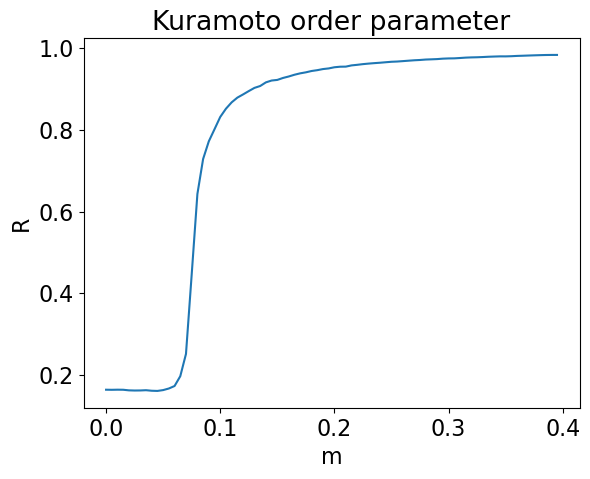

In [73]:
R_mean=jnp.mean(R, axis=1)

m_array = np.arange(0,0.4,.005)
print(m_array.shape, R_mean.shape)
plt.plot(m_array, R_mean)
plt.xlabel('m')
plt.ylabel('R')
plt.title('Kuramoto order parameter')
plt.savefig('figures/kuramoto_order_parameter_brain._long.png')

## Pattern entropy

## Plotting pmf

In [12]:
# normalisation wrt to total number of possible patterns, right one

def calculate_entropy_jax(binary_arrays, s, size=None):
    """
    Calculate the entropy of the patterns contained in a set of binary arrays.
    Parameters:
        binary_arrays (jax.numpy.ndarray): A 2D array of binary arrays (N, T).
        s (int): The length of each binary array.
    Returns:
        tuple: A tuple containing:
            - float: The entropy of the binary arrays.
            - float: The normalized entropy of the binary arrays.
    """
    # Calculate the number of unique patterns and their counts
    unique_patterns, counts = jnp.unique(binary_arrays, axis=1, return_counts=True, size=size)
    total_patterns = jnp.sum(counts)


    probabilities = (counts+1) / (total_patterns+2**s)
    unobserved= 2**s- len(counts)
    # Compute entropy using JAX
    entropy_obs = -jnp.sum(probabilities * jnp.log2(probabilities))
    entropy_un=-unobserved/(total_patterns+2**s)*jnp.log2(1/(total_patterns+2**s))
    entropy=entropy_obs+entropy_un

    # Normalize entropy
    N = binary_arrays.shape[0]  # Length of each binary array
    max_entropy = N  # Maximum entropy for binary arrays of length N
    normalized_entropy = entropy / max_entropy

    return entropy, normalized_entropy, probabilities,unobserved, total_patterns


In [23]:
a=u_solutions_loaded[-1,:9,1000:]
print(a.shape)
binary_u = jnp.where(a > 0.05, 1, 0)
entropy, normalized_entropy, probabilities,unobserved, tot = calculate_entropy_jax(binary_u, 9)
# Append unobserved cells with value tot to the probabilities array
probabilities = jnp.append(probabilities, jnp.full(unobserved, 1 / (tot + 2**9)))


(9, 5000)


"\n# Remove upper and right side of the box\nax = plt.gca()\nax.spines['top'].set_visible(False)\nax.spines['right'].set_visible(False)\n"

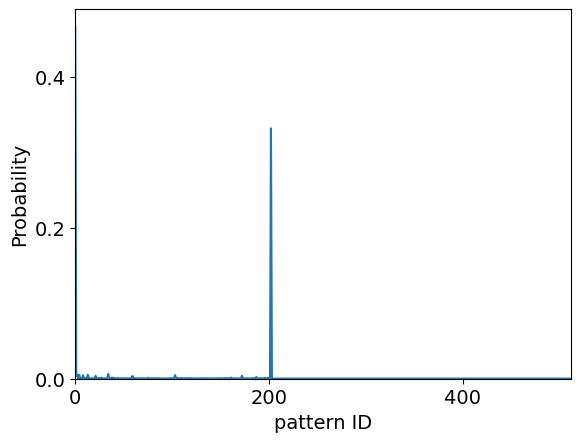

In [24]:
plt.plot(probabilities)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.locator_params(axis='x', nbins=3)
plt.locator_params(axis='y', nbins=3)
plt.ylim(0)
plt.xlim(0,np.size(probabilities))
plt.xlabel('pattern ID', fontsize=14)
plt.ylabel('Probability', fontsize=14)

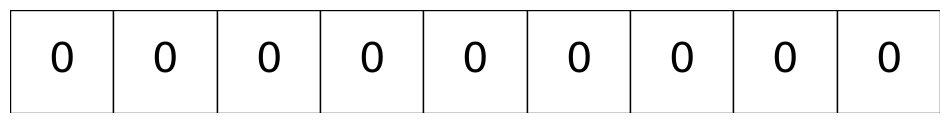

In [31]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# plot all zeros inside the boxes
fig, ax = plt.subplots(figsize=(12, 2))


num_boxes = 9
box_size = 1

# Plot each box with a 1 inside
for i in range(num_boxes):
    # Add a rectangle for the box
    rect = patches.Rectangle((i, 0), box_size, box_size, facecolor='white', edgecolor='black')
    ax.add_patch(rect)
    # Add the text inside the box
    ax.text(i + 0.5, box_size / 2, '0', ha='center', va='center', fontsize=30)

# Set the limits and remove the axes
ax.set_xlim(0, num_boxes)
ax.set_ylim(0, box_size) 
ax.set_aspect('equal')  
ax.axis('off')



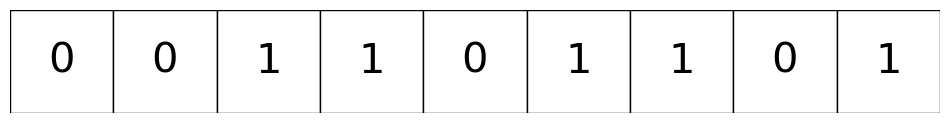

In [41]:

import random

fig, ax = plt.subplots(figsize=(12, 2))


num_boxes = 9
box_size = 1  # Set the size of each box to 1 (making them squares)

# Generate a random sequence of 1s and 0s
binary_sequence = [random.choice([0, 1]) for _ in range(num_boxes)]

# Plot each box with a random 1 or 0 inside
for i in range(num_boxes):
    # Add a rectangle for the box
    rect = patches.Rectangle((i, 0), box_size, box_size, facecolor='white', edgecolor='black')
    ax.add_patch(rect)
    # Add the text (random 1 or 0) inside the box
    ax.text(i + 0.5, box_size / 2, str(binary_sequence[i]), ha='center', va='center', fontsize=30)

# Set the limits and remove the axes
ax.set_xlim(0, num_boxes)
ax.set_ylim(0, box_size) 
ax.set_aspect('equal') 
ax.axis('off')



## Proper entropy caalculation

In [ ]:
# normalisation wrt to total number of possible patterns, right one

def calculate_entropy_jax(binary_arrays, s, size=None):
    """
    Calculate the entropy of the patterns contained in a set of binary arrays.
    Parameters:
        binary_arrays (jax.numpy.ndarray): A 2D array of binary arrays (N, T).
        s (int): The length of each binary array.
    Returns:
        tuple: A tuple containing:
            - float: The entropy of the binary arrays.
            - float: The normalized entropy of the binary arrays.
    """
    # Calculate the number of unique patterns and their counts
    unique_patterns, counts = jnp.unique(binary_arrays, axis=1, return_counts=True, size=size)
    total_patterns = jnp.sum(counts)


    probabilities = (counts+1) / (total_patterns+2**s)
    unobserved= 2**s- len(counts)
    # Compute entropy using JAX
    entropy_obs = -jnp.sum(probabilities * jnp.log2(probabilities))
    entropy_un=-unobserved/(total_patterns+2**s)*jnp.log2(1/(total_patterns+2**s))
    entropy=entropy_obs+entropy_un

    # Normalize entropy
    N = binary_arrays.shape[0]  # Length of each binary array
    max_entropy = N  # Maximum entropy for binary arrays of length N
    normalized_entropy = entropy / max_entropy

    return entropy, normalized_entropy


In [23]:
@jit
def entropycalc(array, s):
    """
    This function binarizes the input array based on a threshold value, reshapes it, 
    and then calculates the entropy and normalized entropy using the `calculate_entropy_jax` function.


    Parameters:
    array (ndarray): The input array to be binarized and analyzed.
    s (int): The size parameter used for reshaping the array (length of one side of the box).

    Returns:
    tuple: A tuple containing:
        - entropy (float): The calculated entropy of the binarized array.
        - normalised (float): The normalized entropy of the binarized array.
    """
    threshold = 0.05
    binary_u = jnp.where(array > threshold, 1, 0)
    
    binary_u=binary_u[:, 1000:]
    entropy, normalised=calculate_entropy_jax(binary_u,s, 1)
    return entropy, normalised

In [26]:


def split_and_calculate_entropy(array, frame_size=9):
    """
    Splits the input array into smaller sequences of size (frame_size, T)
    and calculates the entropy for each sequence using the entropycalc function.
    
    Parameters:
        array (jnp.ndarray): Input array of shape (N, T).
        frame_size (int): Size of the smaller sequences. Default is 4.
        
    Returns:
        jnp.ndarray: Array of entropies for each sequence.
        jnp.ndarray: Array of normalized entropies for each sequence.
    """
    N, T = array.shape
    num_frames = N // frame_size

    def calculate_entropy_for_frame(i):
        frame = lax.dynamic_slice(array, (i, 0), (frame_size, T))
        return entropycalc(frame, frame_size)

    indices = jnp.arange(0, N, frame_size)
    
    entropies, normalized_entropies = vmap(calculate_entropy_for_frame)(indices)

    return jnp.mean(entropies), jnp.mean(normalized_entropies)

In [15]:
ent=[]
norma=[]
for i in range(len(u_solutions_loaded)):
    entr, norm = split_and_calculate_entropy(u_solutions_loaded[i, :,:], frame_size=10)
    ent.append(entr)
    norma.append(norm)

In [27]:
entr, norm = split_and_calculate_entropy(u_solutions_loaded[0, :,:], frame_size=10)

In [16]:
ent=np.array(ent)
norma=np.array(norma)
print(ent.shape)

(80,)


Text(0.5, 1.0, 'Entropy of the patterns')

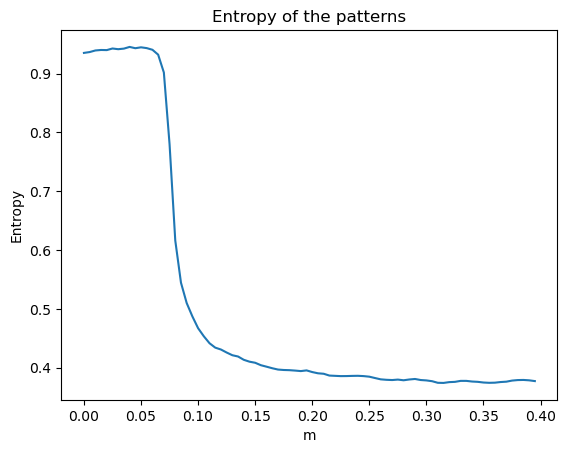

In [17]:
plt.plot(m_array, norma)
plt.xlabel('m')
plt.ylabel('Entropy')
plt.title('Entropy of the patterns')
#plt.savefig('figures/entropy_brain_normalised_long.png')

## Coherence

In [19]:


def calculate_coherence_sliding_window_jax(V, window_size, step_size=1):
    """
    Calculate the coherence order parameter R_V(t) using a sliding window approach.
    
    Args:
        V (jax.numpy.DeviceArray): A (N, T) array where N is the number of neurons, and T is the number of time steps.
        window_size (int): Size of the sliding window (number of time steps).
        step_size (int): Step size for sliding the window (default is 1).
        
    Returns:
        jax.numpy.DeviceArray: An array of coherence values R_V(t) for each window.
    """
    N, T = V.shape  # Number of neurons and time points
    
    # Function to calculate coherence for a single window
    def coherence_for_window(start_idx):
        V_window = lax.dynamic_slice(V, (0, start_idx), (N, window_size))  # Extract window
        
        # Step 1: Population mean at each time step
        V_bar = jnp.mean(V_window, axis=0)  # Shape: (window_size,)
        
        # Step 2: Numerator (variance of population mean over neurons)
        V_bar_squared_mean = jnp.mean(V_bar**2)  # ⟨V̄(t)²⟩
        V_bar_mean_squared = jnp.mean(V_bar)**2  # ⟨V̄(t)⟩²
        numerator = jnp.sqrt(V_bar_squared_mean - V_bar_mean_squared)
        
        # Step 3: Denominator (variance of individual neurons)
        V_squared_mean = jnp.mean(V_window**2, axis=1)  # ⟨Vᵢ(t)²⟩ over window
        V_mean_squared = jnp.mean(V_window, axis=1)**2  # ⟨Vᵢ(t)⟩² over window
        denominator = jnp.sqrt(jnp.mean(V_squared_mean - V_mean_squared))
        
        # Step 4: Coherence order parameter for the window
        return numerator / denominator
    
    # Calculate coherence for all windows using sliding indices
    window_starts = jnp.arange(0, T - window_size + 1, step_size)
    R_V_t = vmap(coherence_for_window)(window_starts)
    
    return jnp.mean(R_V_t)


In [36]:
## This is only a trial to split into chunks the membrane voltage if necessary

u_tot=u_solutions_loaded[0]

# Define constants
chunk_size =150
start_time = 10  # Starting index for the time dimension
window_size = 500  # Window size for the coherence calculation

# Function to calculate coherence for a chunk
@jit
def process_chunk(start_idx):
    # Slice a chunk of at most `chunk_size` nodes
    chunk = lax.dynamic_slice(u_tot, (start_idx, start_time), (chunk_size, u_tot.shape[1] - start_time))
    return calculate_coherence_sliding_window_jax(chunk, window_size)

# Generate indices for chunk processing
chunk_indices = jnp.arange(0, u_tot.shape[0], chunk_size)

# Use `vmap` to process all chunks efficiently
cohe = vmap(process_chunk)(chunk_indices)

# Combine the coherence results into a single array
cohe = jnp.array(cohe)


In [8]:
cohe=[]
for i in range(len(u_solutions_loaded)):
    c=calculate_coherence_sliding_window_jax(u_solutions_loaded[i,:,1000:], window_size=500, step_size=1)
    cohe.append(c)

In [9]:
cohe=np.array(cohe)
print(cohe.shape)

(80, 4501)


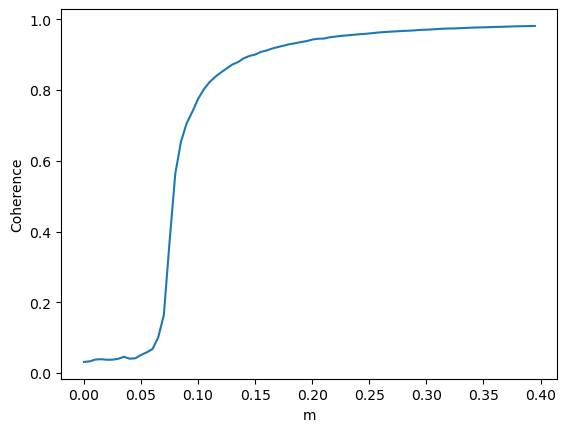

In [10]:
mean=np.mean(cohe, axis=1)
m_array = np.arange(0,0.4,.005)
plt.plot(m_array, mean)
plt.xlabel('m')
plt.ylabel('Coherence')
plt.savefig('figures/coherence_brain_long.png')